In [1]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('../data/xfiles_db.sqlite')
db = conn.cursor()

In [2]:
db.execute('SELECT COUNT(*) FROM XFILES')
assert(db.fetchone()[0] == 64776)

In [3]:
df = pd.read_sql_query('SELECT * FROM XFILES', conn)
assert(df.shape[0] == 64776)
conn.close()
df.head()

,EPISODE,CONVO_NUM,CHARACTER,TEXT
0,TREVOR,0,GUARD,Last wall... Pour it on!\n\n
1,TREVOR,1,WHALEY,(thinking this is all a waste of time) M...
2,TREVOR,2,GUARD,(warning) Whaley!\n\n
3,TREVOR,3,WHALEY,A big hole. The man ought to be givin' us...
4,TREVOR,4,PINKER RAWLS,Shut up and hold it still.\n\n


In [4]:
df.CHARACTER.value_counts().head(15)

MULDER                   14417
SCULLY                   13930
DOGGETT                   2565
SKINNER                   2040
REYES                     1129
CUT TO                     605
BYERS                      420
FROHIKE                    380
KRYCEK                     333
MAN                        319
LANGLY                     311
CIGARETTE SMOKING MAN      219
KERSH                      210
CIGARETTE-SMOKING MAN      206
DOCTOR                     193
Name: CHARACTER, dtype: int64

In [5]:
def clean_characters(char):
    if 'SCULLY' in char:
        return 'SCULLY'
    elif 'MULDER' in char:
        return 'MULDER'
    elif 'CIGARETTE' in char:
        return 'CIGARETTE SMOKING MAN'
    return char

df['CHARACTER'] = df.CHARACTER.apply(clean_characters)
df.drop(df.loc[df.CHARACTER == 'CUT TO'].index, inplace=True)
df.CHARACTER.value_counts().head(15)

MULDER                   15166
SCULLY                   14290
DOGGETT                   2565
SKINNER                   2040
REYES                     1129
CIGARETTE SMOKING MAN      447
BYERS                      420
FROHIKE                    380
KRYCEK                     333
MAN                        319
LANGLY                     311
KERSH                      210
DOCTOR                     193
WOMAN                      171
SPENDER                    169
Name: CHARACTER, dtype: int64

## Basic Word Frequency

In [6]:
dialogue = [txt.strip() for txt in df.TEXT.values]
dialogue[:5]

['Last wall... Pour it on!',
 "(thinking this is all a waste of time)   Man, this little piece of\nwood ain't gonna hold no twister!  We need to dig a hole, you know what I'm\nsaying?",
 '(warning)   Whaley!',
 "A big hole.  The man ought to be givin' us shovels.  This whole\ndamn place is going to blow away.  Why even bother?  Yo, boy, back me up,\nhere!",
 'Shut up and hold it still.']

I want to avoid the overhead of nltk, gensim and spacy, and also want full control.

In [7]:
from collections import Counter
from functools import lru_cache
from stop_words import get_stop_words
from string import punctuation


word_counts = Counter()
stop_words = get_stop_words('en') + ['']


@lru_cache(maxsize=1024)
def clean_word(wrd):
    clear = ["'", '-', '\x92', ',', '\x97', '.', '\x94'] + list(punctuation)
    clean = wrd.lower().strip().translate({ord(c): None for c in clear})
    return clean


word_counts.update([clean_word(wrd) for txt in dialogue for wrd in txt.split() \
                    if clean_word(wrd) not in stop_words])

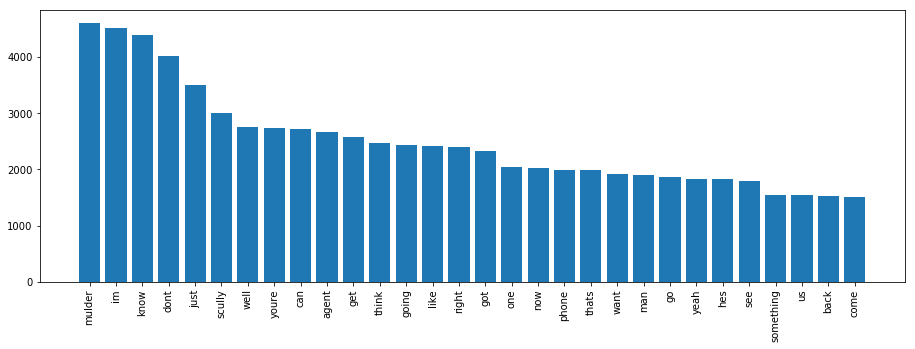

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
 
n = 30
left = list(range(n))
to_plot = word_counts.most_common(n)
labels, heights = zip(*to_plot)

plt.bar(left, heights); plt.xticks(left, labels, rotation=90)
fig = plt.gcf()
fig.set_size_inches(15.5, 5.0)
plt.show()

## Scully Response Word Count Matrix

We want to form a word count matrix $M$ which is defined by

$$
M_{ij} = \text{# of times word $i$ was spoken before Scully responded with word $j$}
$$

In [9]:
import numpy as np

# minimum number of times a word should appear
lb = 5

# for performing lookups
vocab = [wrd for wrd, count in word_counts.items() if count > lb]
index_of = {w: i for i, w in enumerate(vocab)}
word_at = {i: w for w, i in index_of.items()}

n = len(index_of) # ~6592
m = np.zeros((n, n))

In [10]:
import itertools


def update_entry(prev_said, current, matrix=m):
    for w1, w2 in itertools.product(prev_said, current):
        if index_of.get(w1) and index_of.get(w2):
            m[index_of[w1], index_of[w2]] += 1
        
    
def update_matrix_with_episode(data, matrix=m):
    "Updates the Word Count Matrix m with episode data"

    last_spoke, last_said = None, None

    for idx, row in data.iterrows():
        char = row['CHARACTER']
        dialogue = [clean_word(wrd) for wrd in row['TEXT'].split() if clean_word(wrd) not in stop_words]
        if char == 'SCULLY':
            if last_said is not None:
                update_entry(last_said, dialogue, matrix=matrix)
            last_spoke = char
            continue 
            
        if char == last_spoke:
            last_said.extend(dialogue)
            continue
               
        last_spoke, last_said = row['CHARACTER'], dialogue

In [11]:
%%time
for episode, ep_df in df.sort_values(by=['EPISODE', 'CONVO_NUM']).groupby('EPISODE'):
    update_matrix_with_episode(ep_df)

CPU times: user 11.2 s, sys: 194 ms, total: 11.4 s
Wall time: 11.5 s


In [12]:
print('To get Scully\'s attention, say "{}"'.format(word_at[m.sum(axis=1).argmax()]))
print('Scully will probably respond with "{}"'.format(word_at[m.sum(axis=0).argmax()]))

To get Scully's attention, say "scully"
Scully will probably respond with "mulder"


## Determine if Scully would respond

In [13]:
from sklearn.naive_bayes import MultinomialNB

In [14]:
naive = MultinomialNB(alpha=1.0, fit_prior=False)